Import the papers csv as a dataframe

In [2]:
import pandas as pd
import os

os.chdir('../data')

papers = pd.read_csv("papers.csv")

papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


Drop the columns that arent relevant

In [3]:
papers = papers.drop(columns=['id','event_type','pdf_name'], axis = 1)

papers.head()

,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


Using regex and lowercasing we remove all punctuation and capitals, this cleans the data making it readable for performing accurate LDA analysis

In [4]:
import re

#remove punctuation using re
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

#Convert to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

papers['paper_text_processed'].head()

0    767\n\nself-organization of associative databa...
1    683\n\na mean field theory of layer iv of visu...
2    394\n\nstoring covariance by the associative\n...
3    bayesian query construction for neural\nnetwor...
4    neural network ensembles cross\nvalidation and...
Name: paper_text_processed, dtype: object

Use wordcloud to verify that the preprocessing has been done correctly and to get an understanding of the content of the data

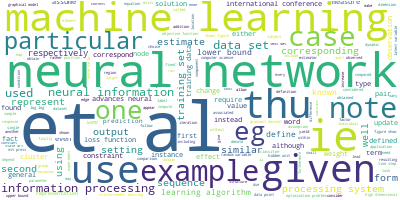

In [5]:
from wordcloud import WordCloud

word_string = ','.join(list(papers['paper_text_processed'].values))

#create wordcloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(word_string)

wordcloud.to_image()

We want to convert the data into something usable. We want to create a vector representation of the documents (Bag-Of-Words). We want to then extract vocabulary vectors for each document (no of times each word appears in each document). Then plot the 10 most common words that occur across all the documents. 

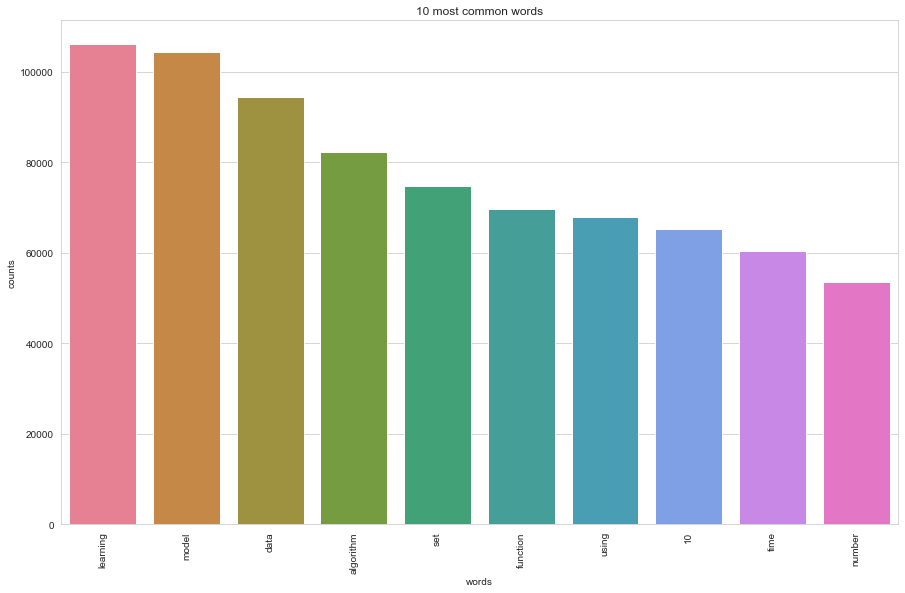

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper fn - Takes a set of fit_transorm()'d data and extracts the 10 most common words and then plots them in a graph
def plot_10(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names() # == BOW
    total_counts = np.zeros(len(words)) # Initialise array of 0's the same length as the BOW
    for t in count_data:
        total_counts+=t.toarray()[0] # Sum all occurances of each word (flatten the 7241 vectors into a single vector)
    
    count_dict = (zip(words, total_counts)) # create nested tuple of word/count
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10] # sort the data by the count, slice top 10
    words = [w[0] for w in count_dict] # create word list for x-axis
    counts = [w[1] for w in count_dict] # create count list for y-axis
    x_pos = np.arange(len(words)) # x-position ticks

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise count vectorizer with English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# fit and transform the documents
# this creates a vocubulary that covers all the documents
# it then creates a vocubulary vector for each document (no of instances of each word in each doc)
# 7241 documents, composed by a vocabulary of 302286 words
count_data = count_vectorizer.fit_transform(papers['paper_text_processed'])

res = plot_10(count_data, count_vectorizer)

In [7]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import LatentDirichletAllocation as LDA

# helper fn - prints the topics and their top n associated words
def print_topics(model, count_vectorizer, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        words = count_vectorizer.get_feature_names()
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Alter n_topics to find the best model (would use stats etc here to quantify)
n_topics = 5
# No of words to display per topic
n_words = 10

# create and fit the LDA model using the sklearn algorithm and the given No of topics
lda = LDA(n_components = n_topics, n_jobs=-1)
lda.fit(count_data)

# print topics
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, n_words)

Topics found via LDA:

Topic #0:
time network neural model input figure neurons learning neuron output

Topic #1:
data matrix learning algorithm problem set kernel 10 method using

Topic #2:
model learning training image network using networks images neural set

Topic #3:
model data distribution models 10 gaussian using log set inference

Topic #4:
algorithm learning function set bound problem algorithms log theorem optimal


Now we have the topics, we can use pyLDAvis to analyse the data. We can view the most frequent (relevant) terms - allowing assignment of topic meaning by a person.

Intertopic distance plot - shows you the relationship between topics via their ovelap

In [8]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle
import pyLDAvis

pyLDAvis.enable_notebook()
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
LDAvis_prepared

c:\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.098580  0.059493       1        1  22.541735
1     -0.081237 -0.023485       2        1  22.153860
3     -0.036081 -0.001336       3        1  21.804820
2      0.063129 -0.102696       4        1  19.130411
0      0.152769  0.068024       5        1  14.369174, topic_info=       Category           Freq       Term          Total  loglift  logprob
201629  Default  102569.000000      model  102569.000000  30.0000  30.0000
207886  Default   43925.000000    network   43925.000000  29.0000  29.0000
162992  Default   29436.000000      image   29436.000000  28.0000  28.0000
208290  Default   13452.000000    neurons   13452.000000  27.0000  27.0000
194320  Default   42636.000000     matrix   42636.000000  26.0000  26.0000
...         ...            ...        ...            ...      ...      ...
120481   Topic5    6374.127261  different   35949.193362   0.2102  -5.9995
254823   Topic5    5876.952968      shown   22113.442075   0.6149  -6.0807
261733   Topic5    6160.044121      state   34092.402910   0.2291  -6.0336
281681   Topic5    6033.350122       used   44966.488860  -0.0685  -6.0544
281793   Topic5    5765.176748      using   66833.084143  -0.5103  -6.0999

[508 rows x 6 columns], token_table=        Topic      Freq  Term
term                         
11858       1  0.193130    10
11858       2  0.297929    10
11858       3  0.272539    10
11858       4  0.117534    10
11858       5  0.118888    10
...       ...       ...   ...
299097      4  0.005484   yor
300507      3  0.995782   zdn
301178      2  0.991533  zien
301666      3  0.992254   znk
301666      4  0.004470   znk

[1334 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])